# Exploring the parameter space with LDA

Linear Discriminant Analysis (LDA) is a method that tries to model the difference between classes by dimensionality reduction. In this notebook we show that LDA can be a useful tool for sensitivity analysis when the input parameters are continuous but the output is a class.

See the [wiki](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) for more background.

In [21]:
# First load the dependencies
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np

# Set the relevant parameters and filepath
params = ['p_uf', 'p_pu', 'p_up', 'p_fl', 'p_lu', 'g', 'ratio', 'N', 'size']
file_path = '../Data/batchrun02-02-2018.csv'

# Read the data and process it
data = pd.read_csv(file_path)
    # P1: base: only unassigned foragers
    # P2: only group recruitment + unassigned
    # P3: only pheromone 
    # The rest is P5, where ants are both followers, leaders and pheromones
cls = (data['pheromone'] + data['leaders'] + data['followers'] == 0) + \
    ((data['pheromone'] == 0) & ((data['leaders'] + data['followers']) != 0)) * 2 + \
    (((data['leaders'] == 0) & (data['followers'] == 0)) & (data['pheromone'] != 0)) * 3 
data['class'] = cls

# Extract relevant columns
X = data[params].as_matrix()
y = data['class'].as_matrix()

## Building the LDA
We start the LDA by extracting our independent variables (X) and our dependent variables (y) from the data. Then by singular-value decomposition we project this to a 2-dimensional space where the difference between the classes is maximised.

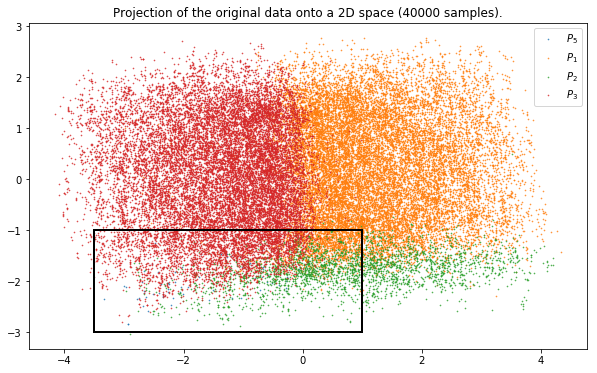

In [22]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
lda.fit(X, y)

# Project the data on the new axes
X_2 = lda.fit_transform(X, y)

# Make a scatter plot of the projection and the classes
classes = ['$P_5$', '$P_1$', '$P_2$', '$P_3$']
for group in [0, 1, 2, 3]:
    plt.scatter(X_2[y == group, 0], X_2[y == group, 1], alpha=.8, label=classes[group], s=0.4)

plt.title("Projection of the original data onto a 2D space ({} samples).".format(data.shape[0]))
plt.legend()

# Highlight the interesting area
corners = np.array([[-3.5, -3],
                    [-3.5, -1.0],
                    [1, -1.0],
                    [1, -3]])
polygon = Polygon(corners, True, alpha=1, edgecolor='k', linewidth=2, fill=False)
ax = plt.gca()
ax.add_patch(polygon)

plt.show()

## Descriptives
We now see clearly that the classes can (mostly) be linearly separated in 2 dimensions. However we see that, unfortunately, the bulk of our runs has been in an uninteresting region. Before we use the projection to reverse-engineer interesting parameter bounds, we first check some general descriptives of the LDA. 

In [23]:
# Print the projection matrix
scalings = pd.DataFrame(lda.scalings_[:,:2].T, index=['x', 'y'], columns=params)
print("The scaling of each parameter to the axes is given in this table:\n{}\n"
      .format(scalings))

# Check the relative contribution of each parameter to the axes
abs_scalings = np.abs(lda.scalings_[:,:2])
rel_scalings = (abs_scalings / np.sum(abs_scalings, axis=0)).T
rel_scalings = pd.DataFrame(rel_scalings, index=['x', 'y'], columns=params)
print("The relative scaling of each parameter to the axes is calculated by dividing the norm of each parameter \
by the row sum.\n{}\n"
      .format(rel_scalings))

# Check the explained variance of the data projection
print("The two new axes of the projection explain respectively {} of the variance between the classes, and are combined \
{} of the variance.\n"
      .format(lda.explained_variance_ratio_, np.sum(lda.explained_variance_ratio_)))

The scaling of each parameter to the axes is given in this table:
      p_uf      p_pu      p_up      p_fl      p_lu         g     ratio  \
x  0.10170  4.248441 -3.564568 -0.031233 -0.502908  0.021297  0.591985   
y -0.86696  0.192226 -0.340237 -0.646254  3.595532 -0.351769 -0.253971   

         N      size  
x -0.00044 -0.004688  
y  0.00050 -0.040962  

The relative scaling of each parameter to the axes is calculated by dividing the norm of each parameter by the row sum.
       p_uf      p_pu      p_up      p_fl      p_lu         g     ratio  \
x  0.011216  0.468547  0.393125  0.003445  0.055464  0.002349  0.065288   
y  0.137866  0.030568  0.054105  0.102769  0.571771  0.055939  0.040387   

          N      size  
x  0.000049  0.000517  
y  0.000079  0.006514  

The two new axes of the projection explain respectively [ 0.87025907  0.12852716] of the variance between the classes, and are combined 0.998786225522146 of the variance.



Not all parameters are in the same range, so the scalings are prone to misinterpretation. However we clearly see that p_up and p_pu are the main responsible parameters on the x-axis, and $p_{lu}$ and the $p_{uf}$ are the main responsible ones for the y-axis. If we look at the raw numbers of the scalings we can also see the effect (positive or negative) each parameter has on its position on projected space (and so on each class). Projecting our data onto these two new axes predicts basically all variance between the classes. 

## Sampling the highlighted subspace

Now we can check the bounds of the parameters in this space:

In [24]:
def inv_transform(lda, x):
    """
    Use the pseudo-inverse since the actual inverse does not exist.
    """
    inv = np.linalg.pinv(lda.scalings_[:,:2])
    return np.dot(x, inv) + lda.xbar_

# Transform these 2D points back to their original dimension
all = inv_transform(lda, corners)

# Get some basic descriptives out of these variables
mins = np.min(all, axis=0)
maxs = np.max(all, axis=0)
avgs = np.mean(all, axis=0)
minmax = pd.DataFrame(np.stack((mins, maxs, avgs)), index=['min', 'max', 'avg'], columns=params)
print("The min, max and avg values of each param in the selected area are:\n{}\n"
      .format(minmax))

The min, max and avg values of each param in the selected area are:
         p_uf      p_pu      p_up      p_fl      p_lu         g     ratio  \
min  0.549109 -0.014054  0.409983  0.543586 -0.263221  0.271989  0.451549   
max  0.683738  0.622086  0.968517  0.637605  0.306757  0.323751  0.571622   
avg  0.616424  0.304016  0.689250  0.590595  0.021768  0.297870  0.511586   

              N       size  
min  255.014882  11.495687  
max  255.015015  11.502035  
avg  255.014948  11.498861  



Some of the values in this table do not make sense; negative minimum values on for the probabilities should be rounded up to zero. These values are caused by the data that is lost when making the LDA transformation and then taking the inverse. By decreasing the dimensionality, we lose accuracy that can not be recovered by inversing the tranformation. 

## Checking the subspace
However, we can now make a meshgrid of these min-max values and linearly interpolate them as a check if these parameters are actually in the correct space. For each parameter we only use 3 points, which should result in $3^{nrparams}$ in the plot. We however only see roughly 27 points in the plot. This gives the indication that only 3 parameters are responsible for those points. 

We make a second meshgrid in which we only min-max interpolate the variables $p_{pu}$, $p_{up}$, and $p_{lu}$, and fix the other parameters. Here we see that our intuition gets confirmed that those 3 parameters are the main effectors of their spatial localisation and we can fix the other parameters when we do a sweep in this subspace.

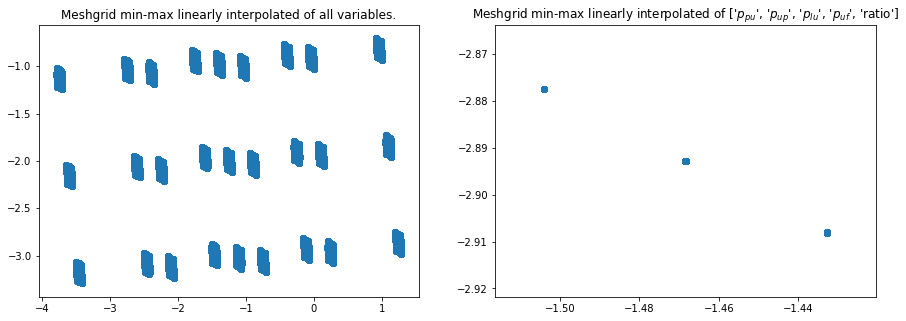

In [25]:
# Lets check how well a meshgrid between the min and max of each parameter fits in between the selected area.
acc = 3
param_ranges = []

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
for i, param in enumerate(params):
    param_ranges.append(np.linspace(mins[i],maxs[i],acc))

mesh = np.meshgrid(*param_ranges)
positions = lda.transform(np.vstack(map(np.ravel, mesh)).T)
plt.scatter(positions[:,0], positions[:,1])
plt.title("Meshgrid min-max linearly interpolated of all variables.")

ax = fig.add_subplot(1, 2, 2)
param_ranges = []
subset = ['$p_{pu}$', '$p_{up}$', '$p_{lu}$', '$p_{uf}$', 'ratio']
for i, param in enumerate(params):
    if param in subset:
        param_ranges.append(np.linspace(mins[i],maxs[i],acc))
    else:
        param_ranges.append(np.linspace(mins[i],mins[i] + 0.00001,acc))
mesh = np.meshgrid(*param_ranges)
positions = lda.transform(np.vstack(map(np.ravel, mesh)).T)
plt.title("Meshgrid min-max linearly interpolated of {}".format(subset))
plt.scatter(positions[:,0], positions[:,1])

# make the final plot
plt.show()

## Sampling the subspace
Our new parameter sweep has been done without $N$ and size, respectively fixed on 40 and 11. These values have been fixed since they seem to predict little difference between the classes. The other parameters were selected from the min-max bounds from the region with the extra requirement that they did not surpass the original bound.

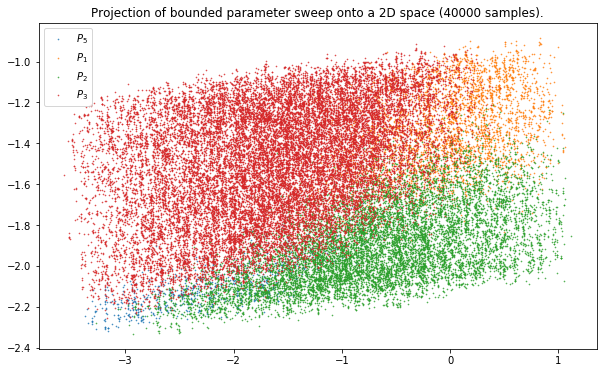

In [27]:
data = pd.read_csv('../Data/batchrun03-02-2018_square.csv')
cls = (data['pheromone'] + data['leaders'] + data['followers'] == 0) + \
      ((data['pheromone'] == 0) & ((data['leaders'] + data['followers']) != 0)) * 2 + \
      (((data['leaders'] == 0) & (data['followers'] == 0)) & (data['pheromone'] != 0)) * 3

data['class'] = cls

X = data[params].as_matrix()
X = lda.transform(X)

y = data['class'].as_matrix()
for group in [0, 1, 2, 3]:
    plt.scatter(X[y == group, 0], X[y == group, 1], alpha=.8, label=classes[group], s=0.4)

plt.title("Projection of bounded parameter sweep onto a 2D space ({} samples).".format(data.shape[0]))
plt.legend()
plt.show()